In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import os

# Memory spaces
- Global vs local memory
- Different strides between elements
- Read in global memory and write in:
    - Global mem
    - Local mem

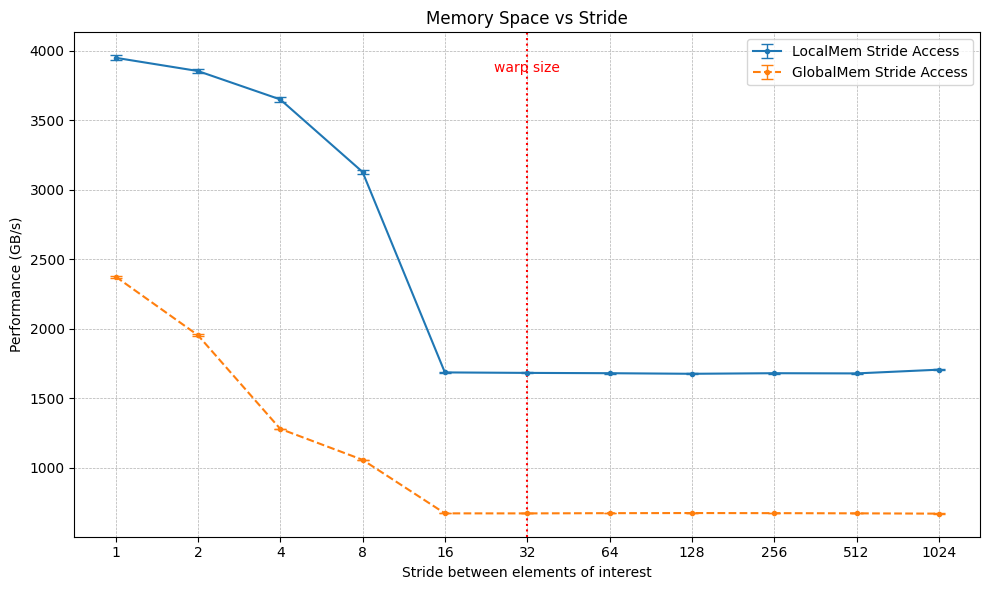

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the JSON file
with open("memory-spaces/run_10reps.json") as f:
    data = json.load(f)

# Convert to DataFrame
df = pd.DataFrame(data["benchmarks"])

# Get mean and stddev entries
means = df[df["aggregate_name"] == "mean"].copy()
stddevs = df[df["aggregate_name"] == "stddev"].copy()

# Use a composite key to match mean and stddev rows
merge_keys = ["run_name", "per_family_instance_index"]
merged = pd.merge(
    means,
    stddevs[merge_keys + ["bytes_per_second"]],
    on=merge_keys,
    suffixes=("", "_stddev")
)

# Memory type & stride
merged["mem_type"] = merged["name"].apply(lambda x: "LocalMem" if "LocalMem" in x else "GlobalMem")
merged["stride"] = merged["n2"]

# Convert performance from B/s to GB/s
merged["GBps"] = merged["bytes_per_second"] / 1e9
merged["GBps_stddev"] = merged["bytes_per_second_stddev"] / 1e9

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

for mem_type, style in [("LocalMem", "-"), ("GlobalMem", "--")]:
    subset = merged[merged["mem_type"] == mem_type].sort_values("stride")

    ax.errorbar(
        subset["stride"],
        subset["GBps"],
        yerr=subset["GBps_stddev"],
        capsize=4,
        elinewidth=1,
        label=f"{mem_type} Stride Access",
        linestyle=style,
        marker='.'
    )

# Log2 scale, but with base-10 tick labels
ax.set_xscale("log", base=2)
xticks = merged["stride"].unique()
xticks.sort()
ax.set_xticks(xticks)
ax.set_xticklabels([str(int(x)) for x in xticks])  # base-10 labels

# Red vertical line at stride=32 with annotation
ax.axvline(x=32, color='red', linestyle=':', linewidth=1.5)
ax.text(32, ax.get_ylim()[1] * 0.95, 'warp size', color='red', ha='center', va='top', fontsize=10)

# Labels and styling
ax.set_xlabel("Stride between elements of interest")
ax.set_ylabel("Performance (GB/s)")
# ax.set_title("Memory Space vs Stride")
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend()
plt.tight_layout()
plt.savefig("h100.pdf")
plt.show()


In [18]:
print(merged[["mem_type", "stride", "GBps", "GBps_stddev"]].head())


   mem_type  stride         GBps  GBps_stddev
0  LocalMem     1.0  3950.993025    18.107171
1  LocalMem     2.0  3855.630929    16.033707
2  LocalMem     4.0  3651.146883    15.667705
3  LocalMem     8.0  3128.949894    13.946065
4  LocalMem    16.0  1685.315775     2.894148
